### Purpose: This script will train a resnet18 CNN to identify a picture of a dessert as one of 5 types: cake, pie, icecream, brownie, or cookie. The output is "export.pkl" which can be used in a web application. 

## Import Required Libraries

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.widgets import *

## Gathering Data

To download images with Bing Image Search, sign up at Microsoft for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [4]:
key = 'XXX'

In [5]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128)>

In [6]:
results = search_images_bing(key, 'cake')
ims = results.attrgot('content_url')
len(ims)

150

In [7]:
dessert_types = 'cake','pie','icecream','brownie', 'cookie'
path = Path('desserts')

In [8]:
if not path.exists():
    path.mkdir()
    for o in dessert_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('content_url'))

In [9]:
fns = get_image_files(path)
fns

(#746) [Path('desserts/cake/00000007.jpg'),Path('desserts/cake/00000004.jpg'),Path('desserts/cake/00000005.jpg'),Path('desserts/cake/00000006.jpg'),Path('desserts/cake/00000003.jpg'),Path('desserts/cake/00000010.jpg'),Path('desserts/cake/00000011.jpg'),Path('desserts/cake/00000012.jpg'),Path('desserts/cake/00000013.jpg'),Path('desserts/cake/00000001.jpg')...]

In [10]:
failed = verify_images(fns)
failed

(#11) [Path('desserts/cake/00000020.jpg'),Path('desserts/cake/00000046.jpg'),Path('desserts/cake/00000135.jpeg'),Path('desserts/pie/00000037.jpg'),Path('desserts/pie/00000110.jpg'),Path('desserts/pie/00000032.jpg'),Path('desserts/icecream/00000085.jpg'),Path('desserts/icecream/00000098.jpg'),Path('desserts/brownie/00000149.jpg'),Path('desserts/cookie/00000016.jpg')...]

In [11]:
failed.map(Path.unlink);

## Training the Model, and Using It to Clean Your Data

#### (SECTION A) This is where you come back to when you're finished cleaning your data

In [13]:
desserts = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [14]:
desserts = desserts.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = desserts.dataloaders(path)

In [15]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.723719,0.535856,0.197279,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.452209,0.221341,0.061224,00:15
1,0.377385,0.207569,0.054422,00:16
2,0.267689,0.182667,0.040816,00:15
3,0.217549,0.176024,0.040816,00:17


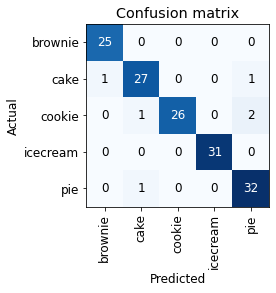

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

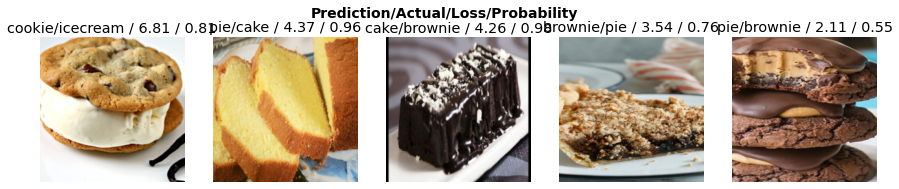

In [31]:
interp.plot_top_losses(5, nrows=1)

In [32]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [27]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Now go back to (SECTION A) and retrain the model

### Export the model for use on an app!

In [17]:
learn.export()

In [18]:
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('export.pkl'),Path('export-resnet34.pkl')]